In [28]:
import Cluster
import cProfile
import glob
import partition
import pickle
import strip
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import imblearn
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn import decomposition
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.base import SamplerMixin

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import svm
import itertools

from sklearn.model_selection import GridSearchCV

# Note to self: reference this in final report submission.
# @article{JMLR:v18:16-365,
# author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
# title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
# journal = {Journal of Machine Learning Research},
# year    = {2017},
# volume  = {18},
# number  = {17},
# pages   = {1-5},
# url     = {http://jmlr.org/papers/v18/16-365}
# }

In [3]:
TILE_SIZE = 25

In [4]:
## Loading
recover = open('./examples/_DONEIN700-SN142.p', 'rb')
input_list = pickle.load(recover)
print(len(input_list))

174257


In [5]:
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    row = [ int(x) for x in row ]
    
    if row[4] > 0:
        cancer_cells.append([row[0], row[1], row[2], row[3]])
    if row[5] > 0:
        T_cells.append([row[0], row[1], row[2], row[3]])
    if row[6] > 0:
        cyto_T_cells.append([row[0], row[1], row[2], row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)

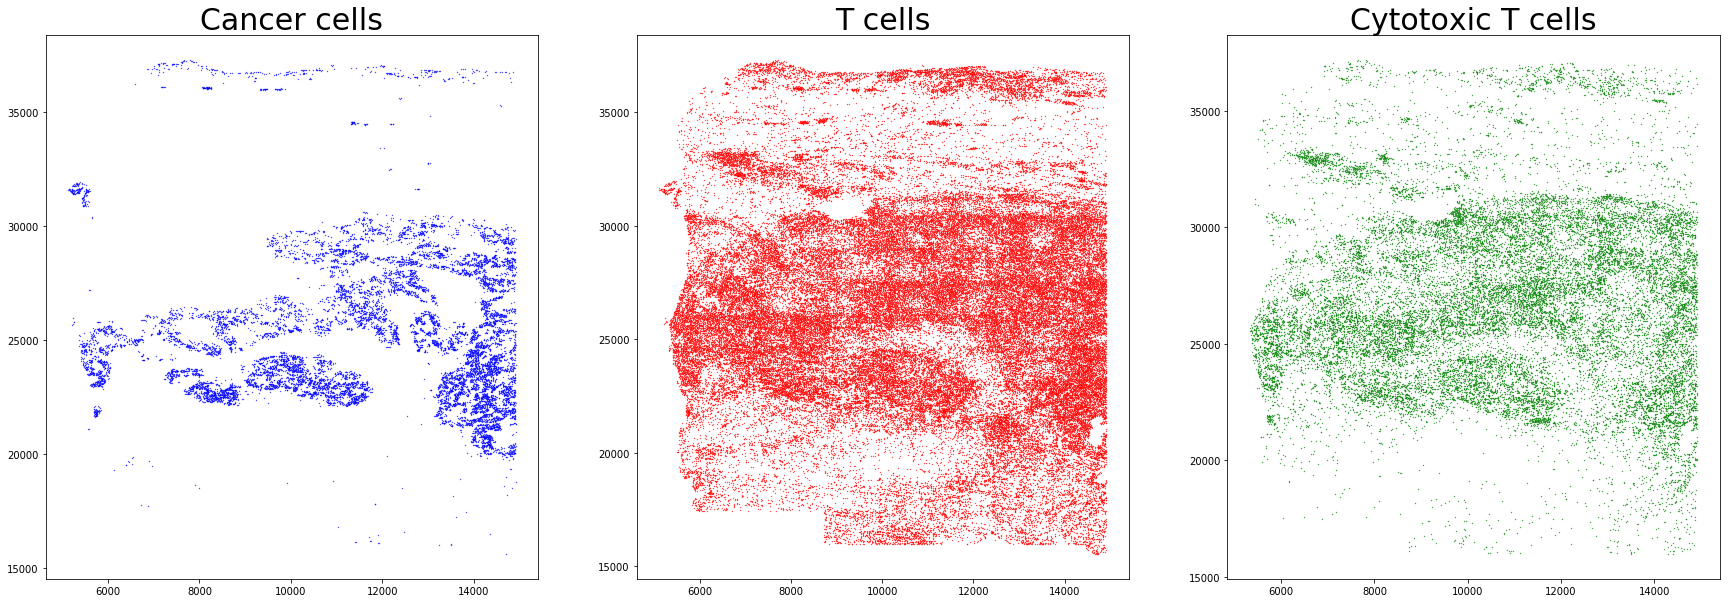

In [6]:
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)

100%|██████████| 25/25 [00:00<00:00, 1461.55it/s]


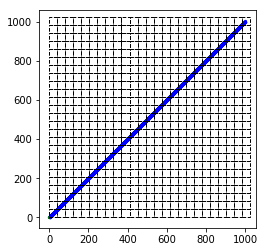

33it [00:00, 326.83it/s]

cleaning...


1000it [00:01, 795.91it/s]
  0%|          | 0/25 [00:00<?, ?it/s]

fishing...



100%|██████████| 25/25 [00:00<00:00, 57.10it/s]/s]

dups (length is 1):


In [7]:
# Example cases for clustering algorithm
NUM_POINTS = 1000

def get_histo(du):
    histogram = np.zeros(21, dtype=np.uint32)
    total_cluster_cells = 0
    for i in du:
        if i is None:
            raise TypeError
        value = len(i.cells)
        total_cluster_cells += len(i.cells)
        if value > 20:
            histogram[20] += 1
        else:
            histogram[value - 1] += 1
    return histogram, total_cluster_cells

check_again = False

if not check_again:
#     random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
    random_xMin = np.arange(NUM_POINTS)
    random_xMax = np.copy(random_xMin) + 3
#     random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
    random_yMin = np.arange(NUM_POINTS)
    random_yMax = np.copy(random_yMin) + 3
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

t = 25
partitioned_random_points, windows_list, w, h = partition.partition(random_points, tile_size=t, to_list=True)
flattened_windows_list = np.array(windows_list).reshape((t*t, 4))

partitioned_total = 0
for i in range(t):
    for j in range(t):
        partitioned_total += len(partitioned_random_points[i][j])

assert(partitioned_total == NUM_POINTS)

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

print("cleaning...")
Cluster_result1 = Cluster.simplest(random_points)
print("fishing...")
Cluster_result2 = Cluster.fishermans_algorithm(partitioned_random_points, t, windows_list, w, h)

dups1 = set()
dups2 = set()

# # Simplest
for key, value in Cluster_result1.items():
    if value not in dups1:
        dups1.add(value)

# # Fisherman's
for i in Cluster_result2:
    if i not in dups2:
        dups2.add(i)

assert(len(dups1) == len(dups2))
print("dups (length is %d):" % len(dups2))

histo1, total_cluster_cells1 = get_histo(dups1)
histo2, total_cluster_cells2 = get_histo(dups2)

if (total_cluster_cells1 != total_cluster_cells2) or not np.array_equal(histo1, histo2):
    print("ERROR")
    print(histo1)
    print(histo2)

cluster <Cluster.Cluster object at 0x121cb90b8> .length:  1000


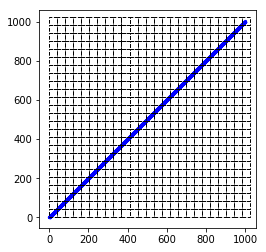

In [8]:
for cluster in dups1:
    cluster_points_xMin = np.array([item[0] for item in cluster.cells])
    cluster_points_xMax = np.array([item[1] for item in cluster.cells])
    cluster_points_yMin = np.array([item[2] for item in cluster.cells])
    cluster_points_yMax = np.array([item[3] for item in cluster.cells])
    print("cluster", cluster, ".length: ", len(cluster.cells))

    fig = plt.figure()
    ax1 = fig.add_subplot(111, aspect='equal')

    ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
    ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

    for window in flattened_windows_list:
        xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
        ax1.add_patch(
            patches.Rectangle(
                (xMin, yMin),   # (x,y)
                xMax - xMin,    # width
                yMax - yMin,    # height
                linestyle='--',
                fill=False
            )
        )
    plt.show()

In [9]:
t = 25
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
print("cells partitioned ...")

100%|██████████| 25/25 [00:00<00:00, 648.21it/s]

cells partitioned ...


In [9]:
# Starts off slowly, as we expect - comparing cells against pretty much every other cell.
# The iterations/s does increase over time though, due to the small optimisation that once we check a cell against
# all of its neighbours, we never check it again. This results in time complexity **roughly** of O(n^2 / 2).
cProfile.run("Cluster.simplest(cancer_cells)")

13804it [03:32, 64.95it/s]

         95655461 function calls in 212.525 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:147(__enter__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
        1    0.000   

In [11]:
# The fishermans algorithm as of 25/1/18 is M I L E S faster than the simple one above, completing in just 10 or so 
# seconds at most in comparison to ~3.5 minutes for the one above.
# This algorithm makes 2209284 neighbour comparisons in comparison to the above algorithm's 95268306.
# That's a difference of nearly 2 orders of magnitude already, and this is for a comparatively very small example. 
# Bigger ones, the gap becomes VAST. Investing time into developing this algorithm was definitely a wise move.
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, tile_size=t, to_list=True)
cProfile.run("Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)")

100%|██████████| 25/25 [00:09<00:00,  2.72it/s]/s]

         2889435 function calls in 9.184 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:147(__enter__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
       26    0.000    0.

In [12]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)

tile_numbers = []
dups = []
histogram = np.zeros(21, dtype=np.uint32)

for i in range(t):
    for j in range(t):
        num = 0
        for value in result:
            if value not in dups:
                dups.append(value)
            num += 1
        tile_numbers.append(num)
        
print("dups (length is %d):" % len(dups))
total_cluster_cells = 0

clusters_sum = 0
dups_length = len(dups)

for i in dups:
    value = len(i.cells)
    clusters_sum += value
    total_cluster_cells += len(i.cells)
    if value > 20:
        histogram[20] += 1
    else:
        histogram[value - 1] += 1
                
clusters_avg = clusters_sum / dups_length

print("Total number of cells:", total_cluster_cells)

print(histogram)

100%|██████████| 25/25 [00:08<00:00,  2.81it/s]/s]


dups (length is 2644):
Total number of cells: 13804
[1275  444  223  138   89   68   51   49   30   22   21   17   16   15
   10   17   12    9    7   13  118]


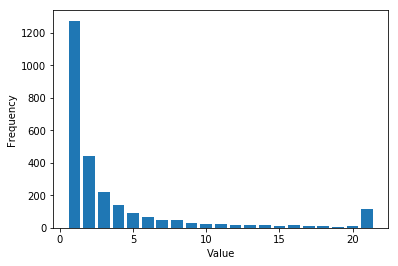

In [17]:
fig = plt.figure()

y = np.array(histogram)
x = np.arange(21) + 1

plt.bar(x, y)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# for cluster in dups:
#     cluster_points_xMin = np.array([item[0] for item in cluster.cells])
#     cluster_points_xMax = np.array([item[1] for item in cluster.cells])
#     cluster_points_yMin = np.array([item[2] for item in cluster.cells])
#     cluster_points_yMax = np.array([item[3] for item in cluster.cells])
#     print("cluster", cluster, ".length: ", len(cluster.cells))

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111, aspect='equal')

#     ax1.scatter(cluster_points_xMin, cluster_points_yMin, s=5, c="b")
#     ax1.scatter(cluster_points_xMax, cluster_points_yMax, s=5, c="b")

#     for window in windows_list:
#         xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#         ax1.add_patch(
#             patches.Rectangle(
#                 (xMin, yMin),   # (x,y)
#                 xMax - xMin,    # width
#                 yMax - yMin,    # height
#                 linestyle='--',
#                 fill=False
#             )
#         )
#     plt.show()

In [171]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [23]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59], dtype=np.float32)

positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        print(file)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    X[i] = arr

for i, example in enumerate(X):
    my_sum = sum(example)
    mean = my_sum / example.size
    stddev = np.std(example)
    
    for j, value in enumerate(example):
        X[i][j] = (value - mean) / stddev  # (max(example) - min(example))
                
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_res, y_res = sampler.fit_sample(X, y)

X_minority = np.take(X_res, np.where(y_res == 1), axis=0)[0]
y_minority = np.take(y_res, np.where(y_res == 1), axis=0)[0]

print(X_minority.shape, y_minority.shape)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)

print(np.sort(X_res))

./inputs/_outDONEIN733-SN103.txt
./inputs/_outDONEIN736-SN97.txt
./inputs/_outDONEIN781-SN7.txt
./inputs/_outDONEIN793-SN74.txt
./inputs/_outDONEIN805-SN126.txt
(34, 21) (34,)
[[-0.43 -0.42 -0.42 ...  0.35  1.15  4.17]
 [-0.4  -0.4  -0.39 ...  0.27  1.04  4.23]
 [-0.45 -0.45 -0.45 ...  0.44  1.05  4.15]
 ...
 [-0.38 -0.37 -0.37 ...  0.23  0.93  4.27]
 [-0.36 -0.36 -0.36 ...  0.16  0.85  4.3 ]
 [-0.35 -0.35 -0.35 ...  0.2   0.92  4.29]]


In [229]:
# pca = decomposition.PCA(n_components=2)
# pca.fit(X)
# X = pca.transform(X)
# clf.fit(X, y)

# fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
# # plot_decision_function(X, y, clf, ax1)
# ax1.scatter(X[:, 0], X[:, 1])
# ax1.set_title('Visualising Data Points compressed with PCA with y={}'.format(Counter(y)))
# fig.tight_layout()

In [74]:
# # X, y = create_dataset(n_samples=10000, weights=(0.01, 0.05, 0.94))
# # sampler = FakeSampler()
# # clf = make_pipeline(sampler, LinearSVC())

# sampler = SMOTE(random_state=0)
# clf = make_pipeline(sampler, LinearSVC())
# print(clf)

# X_train = X
# y_train = y

# clf.fit(X_train, y_train)

# X_res, y_res = sampler.fit_sample(X_train, y_train)
# plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
# # make nice plotting
# plt.spines['top'].set_visible(False)
# plt.spines['right'].set_visible(False)
# plt.get_xaxis().tick_bottom()
# plt.get_yaxis().tick_left()
# plt.spines['left'].set_position(('outward', 10))
# plt.spines['bottom'].set_position(('outward', 10))

(59, 2) (59,)


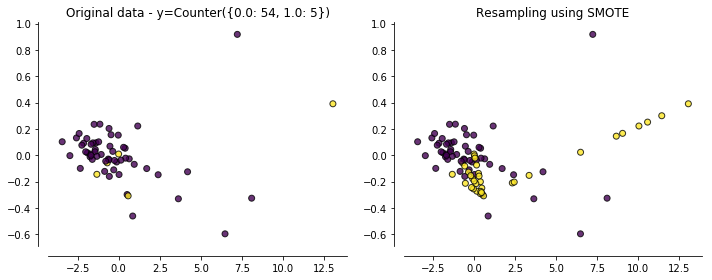

In [88]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

# def plot_decision_function(X, y, clf, ax):
#     plot_step = 0.02
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                          np.arange(y_min, y_max, plot_step))

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     ax.contourf(xx, yy, Z, alpha=0.4)
#     ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

class FakeSampler(SamplerMixin):

    def fit(self, X, y):
        self.ratio_ = 1
        self.X_hash_ = hash_X_y(X, y)
        return self

    def sample(self, X, y):
        return X,

    def _sample(self, X, y):
        pass

    def fit_sample(self, X, y):
        return X, y

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 4))
print(X.shape, y.shape)
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
clf = make_pipeline(sampler, LinearSVC())
clf.fit(X, y)
plot_resampling(X, y, sampler, ax2)
ax2.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

In [228]:
# fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
# plot_decision_function(X, y, clf, ax1)
# ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
# fig.tight_layout()

In [220]:
# X = np.empty((59, 625))

# for i, file in enumerate(glob.glob("./inputs/spatial/*.txt")):
#     f = open(file,'r')
#     lines = f.readlines()
#     arr = np.zeros((25, 25), dtype=np.float32)
    
#     arr_i = 0
#     to_skip = []
#     for x, line in enumerate(lines):
#         if ']' in line and x not in to_skip:
#             cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
#             arr[arr_i] = np.array([int(s) for s in cleaned.split() if s.isdigit()])
#             arr_i += 1
#         elif ']' not in line:
#             cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
#             build_list = [int(s) for s in cleaned.split() if s.isdigit()]
#             index = x
#             while ']' not in line:
#                 index += 1
#                 to_skip.append(index)
#                 line = lines[index]
#                 cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
#                 build_list.extend([int(s) for s in cleaned.split() if s.isdigit()])
#             arr[arr_i] = np.array(build_list)
#             arr_i += 1
    
#     arr = arr.reshape(625)
    
#     my_sum = sum(arr)
#     mean = my_sum / arr.size
#     stddev = np.std(arr)
    
#     for j, value in enumerate(arr):
#         arr[j] = (value - mean)  # / stddev
    
#     arr /= stddev  # stddev

#     X[i] = arr

# print(X.shape)
# y = np.zeros([59], dtype=np.float32)
# positives = [4, 8, 16, 28, 56]

# for index in positives:
#     y[index] = 1

# for (i, pair) in enumerate(zip(X, glob.glob("./inputs/spatial/*.txt"))):
#     (matrix, name) = pair
#     temp = np.array([[int(el) for el in matrix]]).reshape(25, 25).transpose()
#     fig = plt.figure()
#     plt.imshow(temp, cmap='hot', origin='lower')
#     plt.imsave('./inputs/spatial/heatmaps/' + name[17:-4] + '.png', temp, origin='lower', cmap='hot')
#     plt.show()

In [221]:
# pca = decomposition.PCA(n_components=2)
# pca.fit(X)
# X = pca.transform(X)
# clf.fit(X, y)

# fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
# # plot_decision_function(X, y, clf, ax1)
# ax1.scatter(X[:, 0], X[:, 1])
# ax1.set_title('Visualising Data Points compressed with PCA with y={}'.format(Counter(y)))
# fig.tight_layout()

In [223]:
# fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 6))
# plot_decision_function(X, y, clf, ax1)
# ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
# fig.tight_layout()

In [3]:
# clf = svm.SVC(kernel='poly', C=1)
# #predicted = cross_val_predict(clf, X_res, y_res, cv=10)

# # print(scores)
# # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# clf.fit(X_res, y_res) # .predict(y_res)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
# class_names = ['non-fatal', 'fatal']

# clf = svm.SVC(kernel='poly', C=1000)
# y_pred = clf.fit(X_train, y_train).predict(X_test)

# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Unnormalised Confusion Matrix', normalize=True)

# priors = np.array([0.39, 0.61])

# clf = GaussianNB(priors)
# y_pred = clf.fit(X_train, y_train).predict(X_test)

# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Unnormalised Confusion Matrix', normalize=True)

# clf = DecisionTreeClassifier(random_state=0)
# y_pred = clf.fit(X_train, y_train).predict(X_test)

# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Unnormalised Confusion Matrix', normalize=True)

0.8571428571428571
[[14  2]
 [ 0  6]]
0.7058823529411764
[[11  5]
 [ 0  6]]
1.0
[[16  0]
 [ 0  6]]


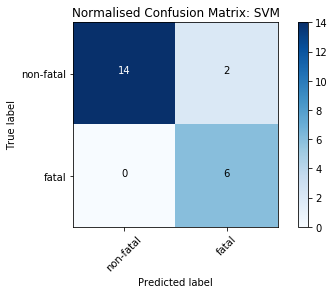

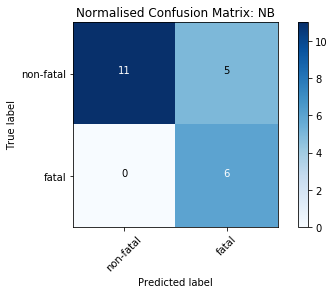

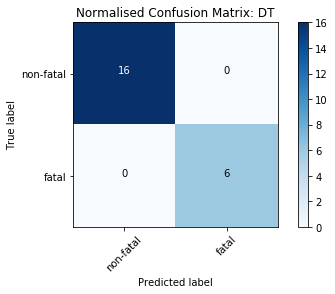

In [32]:
nb_priors = np.array([0.39, 0.61])
svm_params = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 200, 400, 1000]}

class_names = ['non-fatal', 'fatal']

for clf, name in zip([None, GaussianNB(priors), DecisionTreeClassifier(random_state=0)],
                    ["SVM", "NB", "DT"]):
    
    if name == "SVM":
        clf = GridSearchCV(svm.SVC(), svm_params)
        y_pred = clf.fit(X_train, y_train).predict(X_test)
#         y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
    else:
#         y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
        y_pred = clf.fit(X_train, y_train).predict(X_test)

    
    print(f1_score(y_test, y_pred))

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Normalised Confusion Matrix: ' + name, normalize=False)